# <center>Stock Price Prediction Using Deep Learning Technique
&emsp;&emsp;A stock price prediction project utilizing Long Short-Term Memory model. 

## Import Library

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

## Access Data and Input Variables 
&emsp;&emsp;Enter the stock ticker, date, and the epoch times. Noted that the first 80% of the date will be used for training, and the remaining 20% will be used for validation.

&emsp;&emsp;Example Inputs："googl", "2010-01-01", "2023-08-20"

In [25]:
Company = input("Ticker of the Stock:")
Date1 = input("Start(YYYY-MM-DD):")
Date2 = input("End(YYYY-MM-DD):")

Ticker of the Stock:googl
Start(YYYY-MM-DD):2010-01-01
End(YYYY-MM-DD):2023-08-20


## Data Exploration

In [26]:
Data = yf.download(Company,Date1, Date2)
Data =Data.reset_index()
Data

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028
...,...,...,...,...,...,...,...
3425,2023-08-14,129.389999,131.369995,128.960007,131.330002,131.330002,24695600
3426,2023-08-15,131.100006,131.419998,129.279999,129.779999,129.779999,19770700
3427,2023-08-16,128.699997,130.279999,127.870003,128.699997,128.699997,25216100
3428,2023-08-17,129.800003,131.990005,129.289993,129.919998,129.919998,33446300


In [27]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3430 non-null   datetime64[ns]
 1   Open       3430 non-null   float64       
 2   High       3430 non-null   float64       
 3   Low        3430 non-null   float64       
 4   Close      3430 non-null   float64       
 5   Adj Close  3430 non-null   float64       
 6   Volume     3430 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 187.7 KB


In [28]:
Data.isnull().sum() 

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data Visualization

### Stock Price

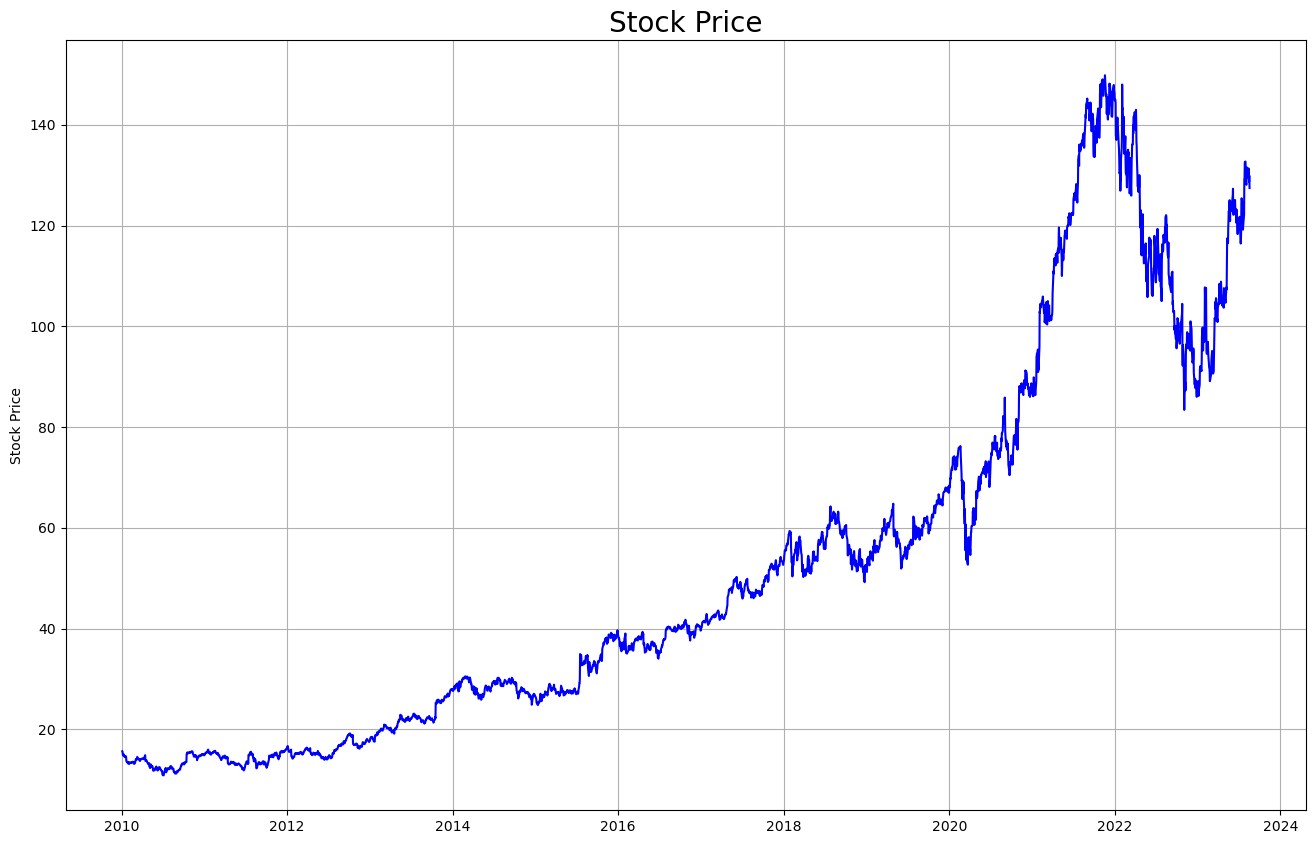

In [29]:
fig, ax = plt.subplots(figsize=(16,10))
plt.title("Stock Price", fontsize="20")
ax.plot(Data["Date"], Data["Close"], color="Blue")
ax.set_ylabel("Stock Price")
plt.grid()
plt.show()

### Moving Average


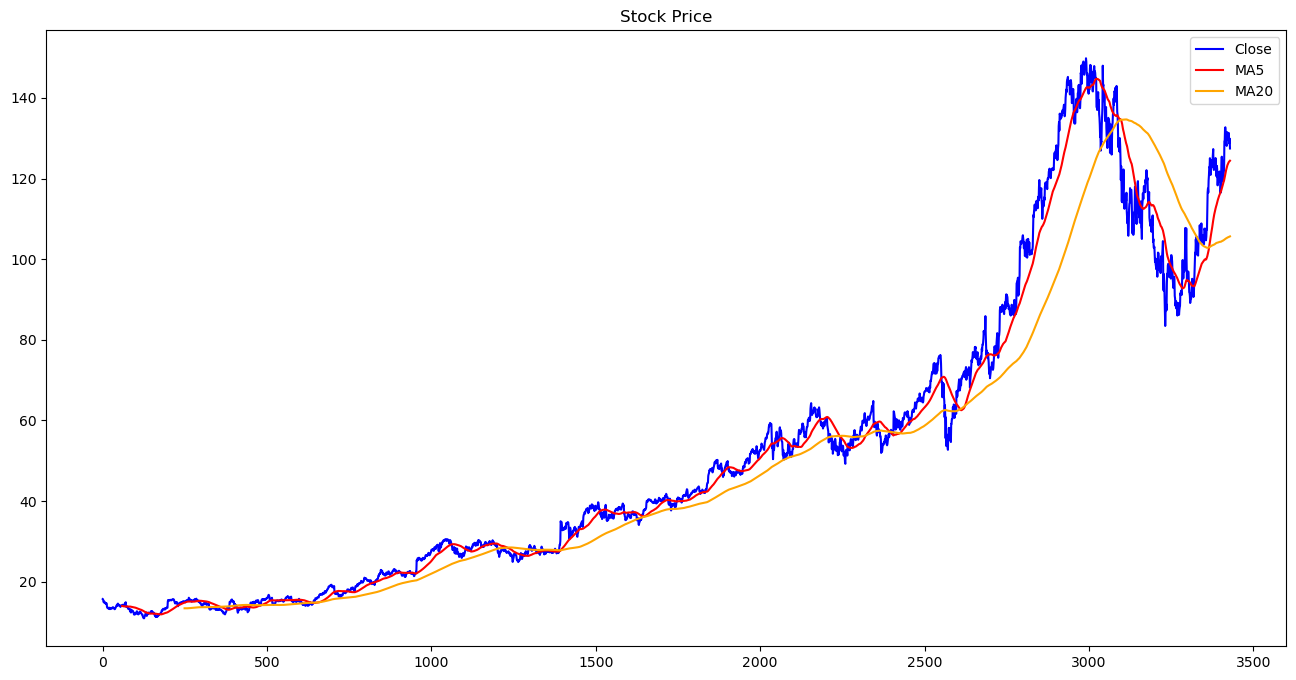

In [30]:
MA60=Data.Close.rolling(60).mean()
MA250=Data.Close.rolling(250).mean()
fig, ax = plt.subplots(figsize=(16,8))
plt.title("Stock Price")
plt.plot(Data.Close, color="Blue", label="Close")
plt.plot(MA60, color = 'Red', label = "MA5")
plt.plot(MA250, color = 'Orange', label = "MA20")
plt.legend()

### Volume

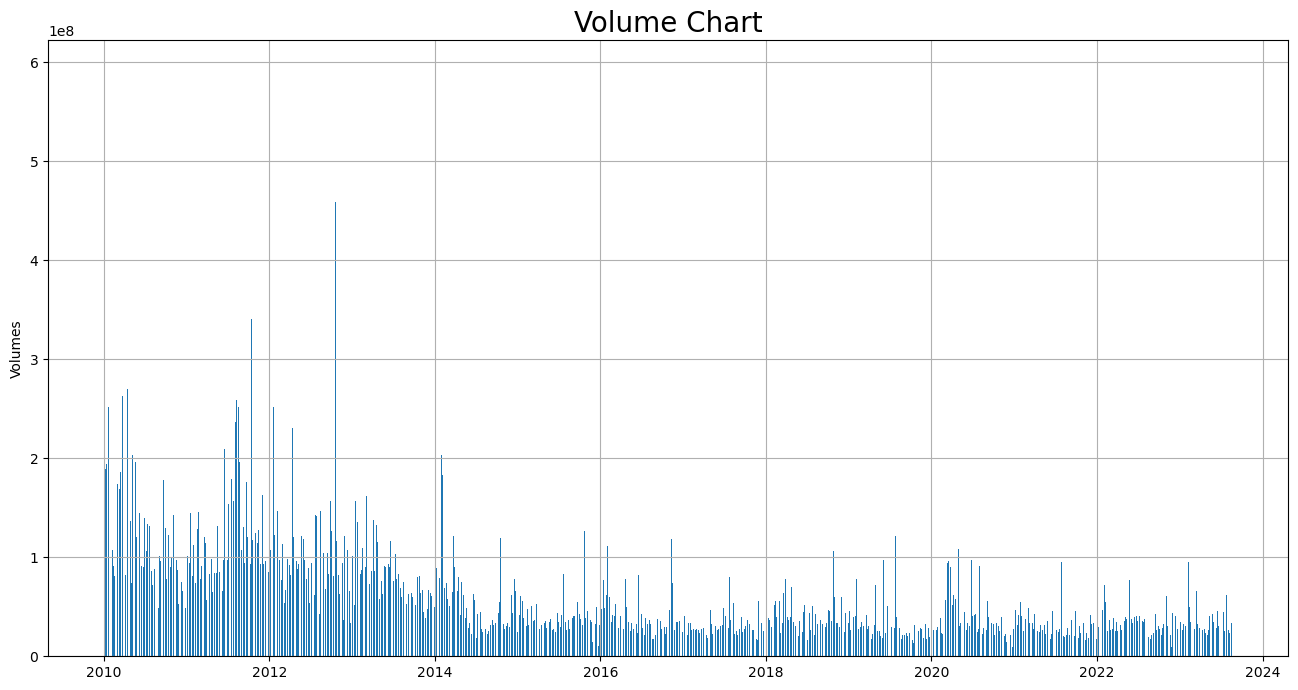

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
plt.title("Volume Chart", fontsize="20")
ax.bar(Data["Date"], Data["Volume"])
ax.set_ylabel("Volumes")
plt.grid()
plt.show()

### Daily Return

In [32]:
Data["Daily Return"] = Data["Close"].pct_change(1)
Data["Daily Return"]

0            NaN
1      -0.004404
2      -0.025209
3      -0.023280
4       0.013331
          ...   
3425    0.013662
3426   -0.011802
3427   -0.008322
3428    0.009479
3429   -0.018935
Name: Daily Return, Length: 3430, dtype: float64

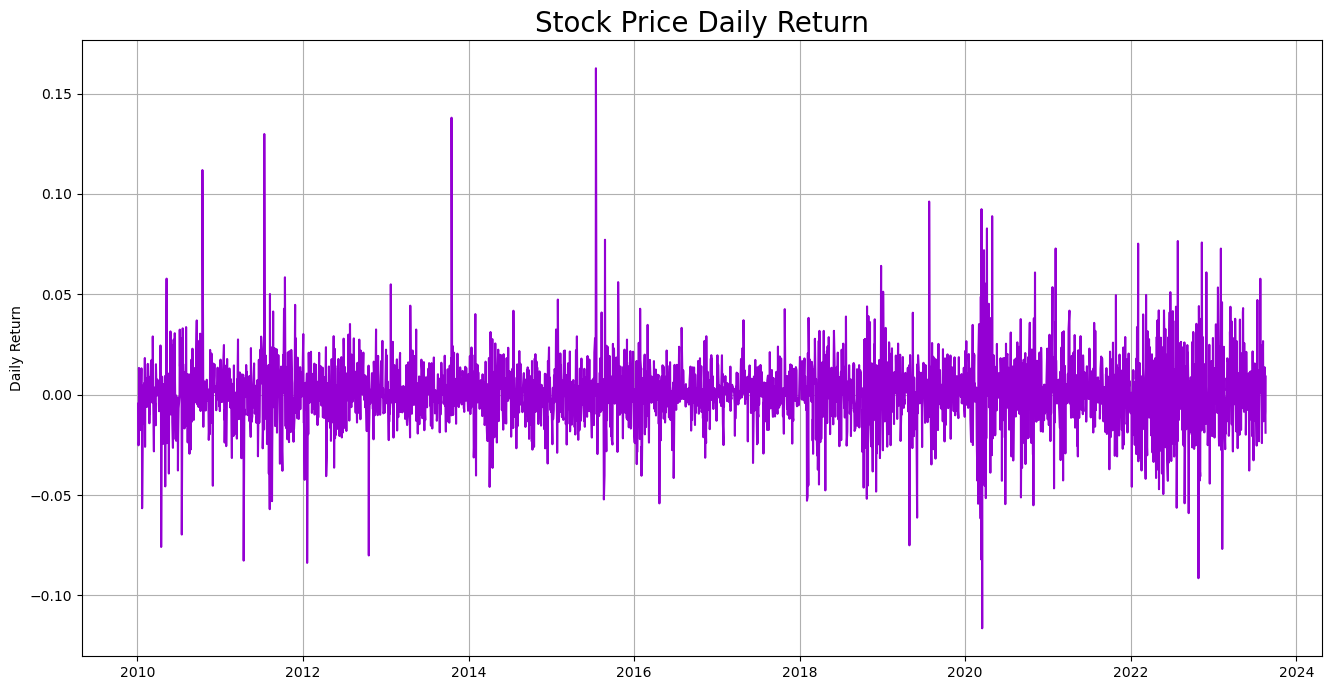

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
plt.title("Stock Price Daily Return",fontsize="20")
ax.plot(Data["Date"], Data["Daily Return"], color="Darkviolet")
ax.set_ylabel("Daily Return")
plt.grid()
plt.show()

<AxesSubplot:>

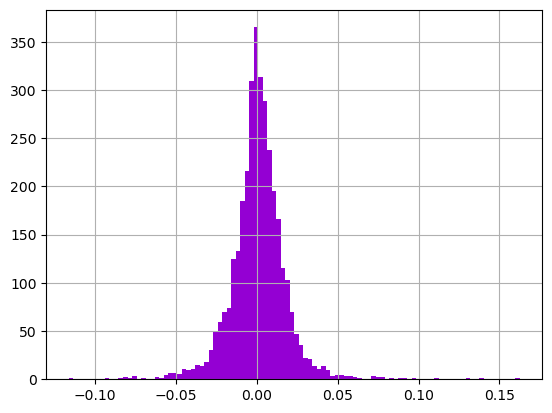

In [34]:
#Distribution of Daily Return(Volatility)
Data.iloc[Data["Daily Return"].argmax()]
Data["Daily Return"].hist(bins=100, color='Darkviolet')

### Cumulative Return

In [35]:
Data["Cumulative Return"] = (1+Data["Daily Return"]).cumprod() 
Data["Cumulative Return"]

0            NaN
1       0.995596
2       0.970499
3       0.947906
4       0.960543
          ...   
3425    8.373270
3426    8.274446
3427    8.205588
3428    8.283372
3429    8.126528
Name: Cumulative Return, Length: 3430, dtype: float64

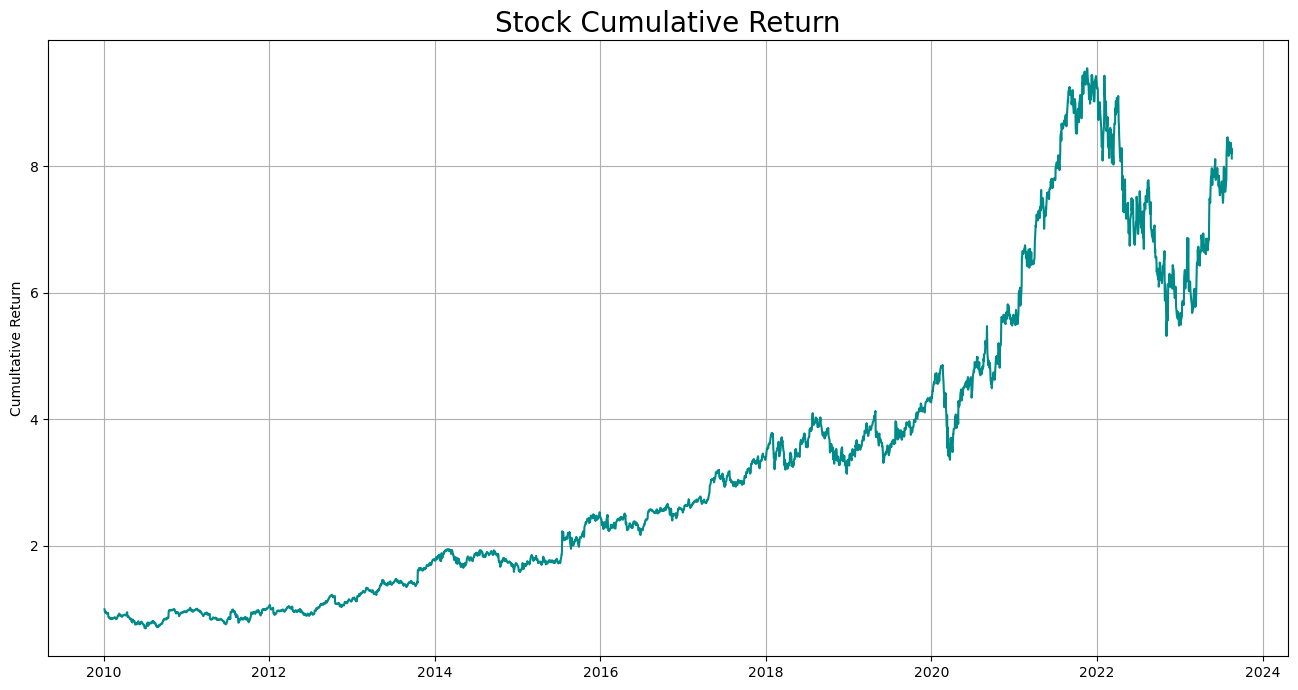

In [36]:
#Cumultative Return of the stock during the given period
fig, ax = plt.subplots(figsize=(16,8))
plt.title("Stock Cumulative Return",fontsize="20")
ax.plot(Data["Date"], Data["Cumulative Return"], color="Darkcyan")
ax.set_ylabel("Cumultative Return")
plt.grid()
plt.show()

### Splitting Data into Training and Validation Sets

In [37]:
Data['Date'] = pd.to_datetime(Data['Date'])
Data.set_index('Date',inplace=True)
Close = Data.filter(['Close'])
CloseValue = Close.values
TrainingDataLength = math.ceil(len(CloseValue)*.8)
TrainingDataLength

2744

###  Scaling data

In [38]:
scaler = MinMaxScaler(feature_range=(0,1))
PriceData = scaler.fit_transform(CloseValue)
PriceData
## Customized the function: 
# def Rank(data):
#     feature_range = data.max() - data.min()
#     scaled_data = (data - data.min()) / feature_range
#     return scaled_data
# PriceData = Rank(CloseValue)
# Rank(CloseValue)

array([[0.03434761],
       [0.03385045],
       [0.03101697],
       ...,
       [0.84784325],
       [0.85662492],
       [0.83891764]])

In [39]:
X_train, Y_train = [],[]
Backcandles = 60
TrainData = PriceData[0:TrainingDataLength] 
for i in range(Backcandles,len(TrainData)):
    X_train.append(TrainData[i-Backcandles:i, 0])
    Y_train.append(TrainData[i,0])
    if i<= Backcandles:
        print("X_train:",X_train,"\nY_train:",Y_train)
X_train,Y_train = np.array(X_train), np.array(Y_train)

X_train: [array([0.03434761, 0.03385045, 0.03101697, 0.02846629, 0.02989295,
       0.02972903, 0.02781422, 0.02720357, 0.02770073, 0.02592643,
       0.02729904, 0.02600028, 0.02646323, 0.02052427, 0.01872114,
       0.01915706, 0.01909942, 0.01769259, 0.01690901, 0.01746381,
       0.01712157, 0.01886885, 0.01633979, 0.01715219, 0.01754487,
       0.01807987, 0.01772141, 0.01807266, 0.01748183, 0.01895531,
       0.0183987 , 0.01930117, 0.01885804, 0.01922551, 0.01783308,
       0.01718461, 0.01627675, 0.01634339, 0.01740437, 0.01891208,
       0.01967945, 0.02134927, 0.02308214, 0.02277051, 0.02235801,
       0.02528697, 0.02613178, 0.02584357, 0.02289661, 0.02326047,
       0.02332532, 0.02347663, 0.02232379, 0.02187345, 0.02034233,
       0.02184283, 0.02284257, 0.02280834, 0.02276511, 0.02353248])] 
Y_train: [0.023606326054810806]


In [40]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(2684, 60, 1)

### LSTM Model Building, Compiling, and Training

In [41]:
Model = Sequential([
    LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    (Dropout(0.2)),
    LSTM((50)),
    (Dropout(0.2)),
    (Dense(32)),
    (Dense(1))
])

Model.compile(optimizer="adam", loss="mean_squared_error") 
Model.fit(X_train, Y_train, batch_size=32, epochs=10)
Model.summary()

Epoch 1/10
84/84 [==============================] - 7s 40ms/step - loss: 0.0024
Epoch 2/10
84/84 [==============================] - 3s 41ms/step - loss: 4.2390e-04
Epoch 3/10
84/84 [==============================] - 3s 41ms/step - loss: 3.9057e-04
Epoch 4/10
84/84 [==============================] - 3s 38ms/step - loss: 3.2045e-04
Epoch 5/10
84/84 [==============================] - 3s 41ms/step - loss: 2.9481e-04
Epoch 6/10
84/84 [==============================] - 3s 37ms/step - loss: 2.5894e-04
Epoch 7/10
84/84 [==============================] - 3s 36ms/step - loss: 2.8030e-04
Epoch 8/10
84/84 [==============================] - 3s 35ms/step - loss: 2.7092e-04
Epoch 9/10
84/84 [==============================] - 3s 36ms/step - loss: 2.6176e-04
Epoch 10/10
84/84 [==============================] - 3s 36ms/step - loss: 2.5057e-04
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (

In [42]:
test_data= PriceData[TrainingDataLength-Backcandles:, :]
x_test, y_test = [], CloseValue[TrainingDataLength:,:]
for i in range(Backcandles,len(test_data)):
    x_test.append(test_data[i-Backcandles:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(686, 60, 1)

## Results of the Prediction

### Root-Mean-Square Error
&emsp;&emsp;A higher RMSE value generally indicates poorer predictive performance. Hence, our training objective is to "minimize RMSE".

In [43]:
Pred = Model.predict(x_test) 
Pred = scaler.inverse_transform(Pred)
RMSE = np.sqrt(np.mean(Pred - y_test)**2)
RMSE


22/22 [==============================] - 1s 13ms/step


0.04337079462435085

### Prediction Results

In [44]:
TrainingSet,ValidationSet = Close[:TrainingDataLength],Close[TrainingDataLength:]
ValidationSet["Predictions"] = Pred
ValidationSet


,Close,Predictions
Date,,
2020-11-25,88.206497,88.461578
2020-11-27,89.350998,88.469009
2020-11-30,87.720001,88.579666
2020-12-01,89.767998,88.632538
2020-12-02,91.248497,88.791084
...,...,...
2023-08-14,131.330002,130.492401
2023-08-15,129.779999,130.603561
2023-08-16,128.699997,130.629379


### Visualization

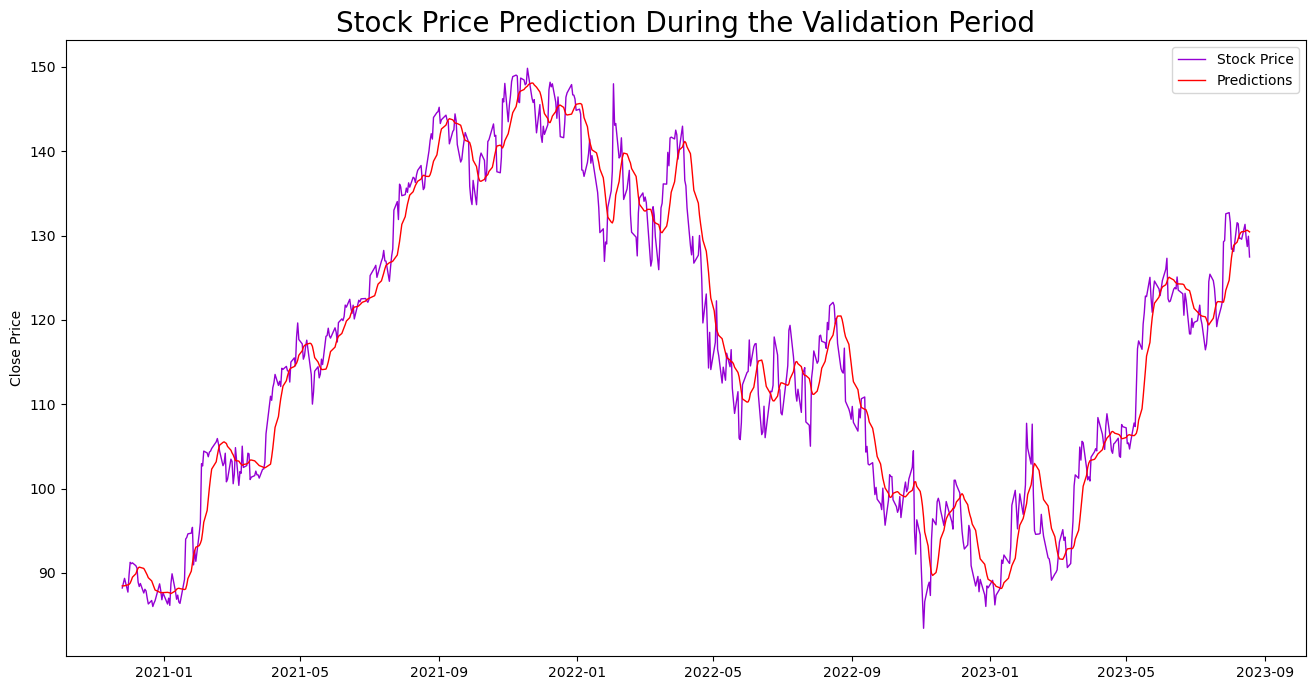

In [45]:
plt.figure(figsize=(16,8))
plt.title("Stock Price Prediction During the Validation Period", fontsize = 20)
plt.ylabel("Close Price")
plt.plot(ValidationSet["Close"],linewidth=1,color = "Darkviolet")
plt.plot(ValidationSet["Predictions"],linewidth=1,color = "Red")
plt.legend(["Stock Price","Predictions"])

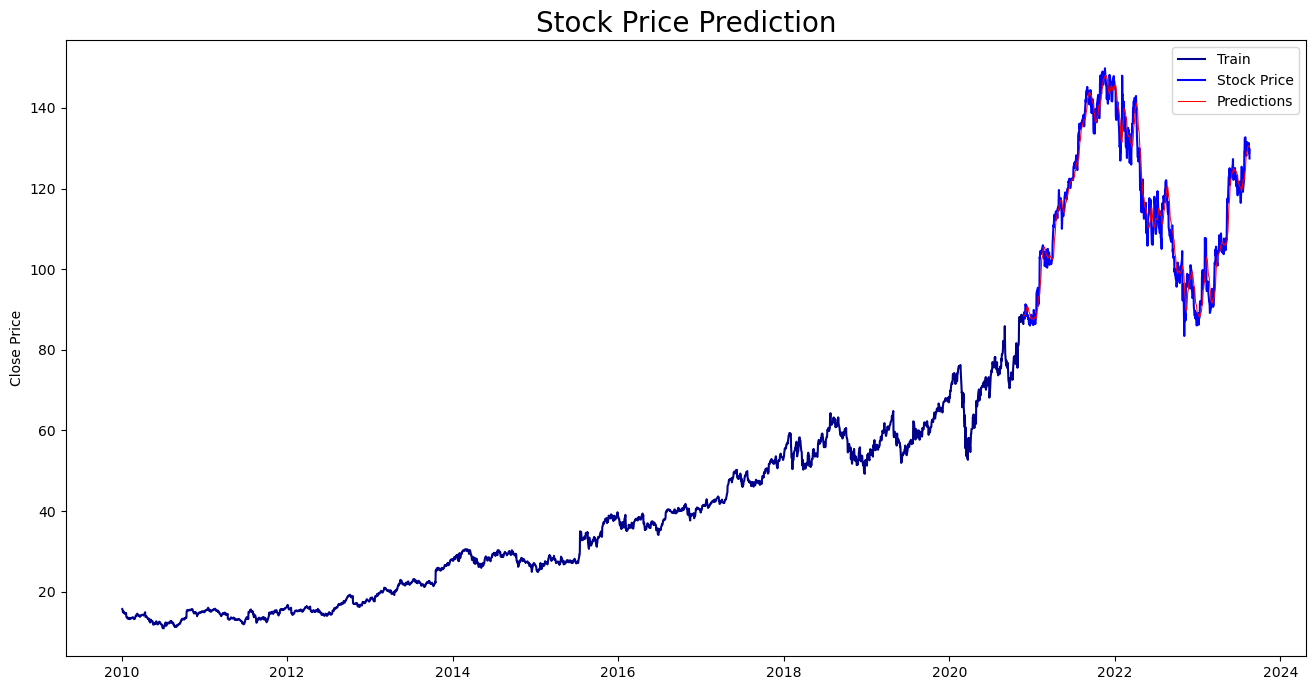

In [46]:
plt.figure(figsize=(16,8))
plt.title("Stock Price Prediction", fontsize=20)
plt.ylabel("Close Price" )
plt.plot(TrainingSet["Close"], color = "Darkblue")
plt.plot(ValidationSet["Close"],color = "Blue")
plt.plot(ValidationSet["Predictions"],linewidth=0.75,color = "Red")
plt.legend(["Train","Stock Price","Predictions"])

### &emsp;&emsp;Please note that using LSTM with raw stock price data is impractical and using min-max scaler to scale the price data is also unreasonable, since the raw stock price data is neither stationarity nor extrpolation. You'll find out it doesn’t work in real-life (The prediction results seems accurate becuase it's nothing but a delay curve :P).
### &emsp;&emsp;When utilizing LSTM for financial data prediction, forecasting "Log Return" might be a better option. This project is better suited as a programming example for basic machine learning rather than a precise stock price prediction.